In [1]:
from Preprocess.Data_load import DataLoad
from Preprocess.Preprocess import text_preprocess, get_processing_df

from transformers import BertTokenizer, BertConfig, BertForTokenClassification
import json
import torch 
import torch.nn

from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

2023-06-29 19:18:32.029843: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-29 19:18:32.215613: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-29 19:18:33.049437: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# 전처리

In [230]:
dl = DataLoad(tran_path='./Data/transcripts.csv', meta_path='./Data/videos.csv')
transcript = dl.load_transcripts()
meta = dl.load_meta()

In [227]:
pop_id, unpop_id = DataLoad.get_id(meta,ratio=0.4)

In [6]:
pop_df = DataLoad.get_df(transcript=transcript,movie_id=pop_id)
pop_script =DataLoad.get_script(pop_df)
unpop_df = DataLoad.get_df(transcript=transcript,movie_id=unpop_id)
unpop_script = DataLoad.get_script(unpop_df)

In [7]:
for id in pop_script.keys() : 
    pop_script[id] = text_preprocess(pop_script[id])
for id in unpop_script.keys() : 
    unpop_script[id] = text_preprocess(unpop_script[id])

[Kss]: Oh! You have mecab in your environment. Kss will take this as a backend! :D



In [8]:
pop_processing_df = get_processing_df(pop_script)
unpop_processing_df = get_processing_df(unpop_script)

# 모델 

In [49]:
pretrained_model_name = "beomi/kcbert-base"
downstream_model_dir = "./Model/pytorch_model.bin"
tokenizer = BertTokenizer.from_pretrained(pretrained_model_name,do_lower_case=False)
fine_tuned_model_ckpt = torch.load(downstream_model_dir,map_location=torch.device("cpu"))

In [50]:
pretrained_model_config = BertConfig.from_pretrained(
    pretrained_model_name,
    num_labels = fine_tuned_model_ckpt['classifier.bias'].shape.numel()
)

model = BertForTokenClassification(pretrained_model_config)

In [51]:
model.load_state_dict(fine_tuned_model_ckpt)

<All keys matched successfully>

In [54]:
# labet tag https://stellarway.tistory.com/29 참조
label_map = open('./Model/config.json', "r").read()
label_map = json.loads(label_map)['id2label']
labels = {}
for idx in label_map.keys() : 
    labels[int(idx)] = label_map[idx]

In [53]:
def inference_fn(sentence):
    inputs = tokenizer([sentence],max_length=128,padding="max_length",truncation=True)
    with torch.no_grad():
        outputs = model(**{k: torch.tensor(v) for k, v in inputs.items()})
        probs = outputs.logits[0].softmax(dim=1)
        _, preds = torch.topk(probs, dim=1, k=1)
        tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
        predicted_tags = [labels[pred.item()] for pred in preds]
        result = []
        for token, predicted_tag in zip(tokens, predicted_tags):
            if all([token not in [tokenizer.pad_token, tokenizer.cls_token, tokenizer.sep_token], len(token) > 2]):
                predicted_tag
                result.append(predicted_tag)
    return result

In [55]:
def exist_label(label_list) : 
    new_label_list = []
    for label in label_list :
        if all([label != 'O',  label[-2:] != '-I']): 
            new_label_list.append(label[:3])
    return new_label_list

In [56]:
inference_fn('첫 번째 문제를 풀어볼게요')

['O', 'O', 'O', 'O']

In [177]:
pop_processing_df['tokenize'] = pop_processing_df['script'].apply(lambda x : tokenizer.tokenize(x))
pop_processing_df['NER-label'] = pop_processing_df['script'].apply(lambda x : inference_fn(x))
unpop_processing_df['tokenize'] = unpop_processing_df['script'].apply(lambda x : tokenizer.tokenize(x))
unpop_processing_df['NER-label'] = unpop_processing_df['script'].apply(lambda x : inference_fn(x))

In [185]:
pop_processing_df['exist_label'] = pop_processing_df['NER-label'].apply(lambda row : exist_label(row) )
unpop_processing_df['exist_label'] = unpop_processing_df['NER-label'].apply(lambda row : exist_label(row) )

In [3]:
import pandas as pd
import ast
from scipy.stats import chi2_contingency
from collections import Counter

In [4]:
# pop_processing_df.to_csv('./Data/pop_processing_NER.csv')
# unpop_processing_df.to_csv('./Data/unpop_processing_NER.csv')
pop_processing_df = pd.read_csv('./Data/pop_processing_NER.csv',index_col=0)
unpop_processing_df = pd.read_csv('./Data/unpop_processing_NER.csv',index_col=0)
pop_processing_df['exist_label'] = pop_processing_df['exist_label'].apply(lambda x : ast.literal_eval(x))
unpop_processing_df['exist_label'] = unpop_processing_df['exist_label'].apply(lambda x : ast.literal_eval(x))

In [74]:
pop_processing_df[1850:1900]

,id,script,tokenize,NER-label,exist_label
1850,JmKNoFeZP4Y,그렇죠 그렇기 때문에 여러분들이 여러 가지 풀이법을 다 활용해서의 값도 구하고 다른...,"['그렇', '##죠', '그렇', '##기', '때문에', '여러분들', '##이...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ...",[]
1851,JmKNoFeZP4Y,자 오늘 공부할 내용은 바로 왜냐면 이 이차방정식의 주어져 있을 때 근의 공식 브레...,"['자', '오늘', '공부', '##할', '내용은', '바로', '왜냐면', '...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ...","[ORG, PER, CVL]"
1852,JmKNoFeZP4Y,일단 암기는 기본이에요,"['일단', '암', '##기는', '기본이', '##에요']","['O', 'O', 'O']",[]
1853,JmKNoFeZP4Y,그런데 도대체 이게 왜 나오냐라는 거죠,"['그런데', '도대체', '이게', '왜', '나오냐', '##라는', '거죠']","['O', 'O', 'O', 'O']",[]
1854,JmKNoFeZP4Y,오늘 수학의 답은 이 공식이 나오는 유도과정을 여러분들과 함께 해 봄으로써 아이는 ...,"['오늘', '수학', '##의', '답은', '이', '공식', '##이', '나...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ...",[]
1855,JmKNoFeZP4Y,같이 함께 공식 유도를 한번 해보도록 할게요,"['같이', '함께', '공식', '유도', '##를', '한번', '해보', '#...","['O', 'O', 'O']",[]
1856,JmKNoFeZP4Y,뭔가 칠판의 가득 문자들이 들어갈 거고 살짝 검날 거예요,"['뭔가', '칠', '##판', '##의', '가득', '문자', '##들이', ...","['O', 'O', 'O', 'O', 'O', 'O']",[]
1857,JmKNoFeZP4Y,하지만 한 단계씩 여러분들과 진행해 보도록 할 겁니다,"['하지만', '한', '단계', '##씩', '여러분들', '##과', '진행',...","['O', 'O', 'O', 'O', 'O', 'O', 'O']",[]
1858,JmKNoFeZP4Y,일단 머릿속에 들어가야 될 딱 한 가지 생각은 그 내공식의 유도는 완전 지급식을 이...,"['일단', '머릿', '##속에', '들어가야', '될', '딱', '한', '가...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ...",[]
1859,JmKNoFeZP4Y,다시 한번 그 음식의 유도는 뭘 갖고 한다,"['다시', '한번', '그', '음식', '##의', '유도', '##는', '뭘...","['O', 'O']",[]


In [75]:
pop_processing_df.loc[[40,49,165,492,1851]]

,id,script,tokenize,NER-label,exist_label
40,2YiZrIJzUsk,아에서한번은분의일다하고산물이뺐어처음에분의분의분의분의그러면이제뭐들어갈차례에요분의을한번...,"['아에', '##서', '##한번', '##은', '##분의', '##일', '#...","['O', 'NUM-B', 'DAT-B', 'DAT-B', 'O', 'O', 'O'...","[NUM, DAT, DAT]"
49,2YiZrIJzUsk,얼마분의두번째건분의긴세번째건불의네번째껀분의다섯번째껀분의그다음은분의쓰는방법은느낌조분모...,"['얼마', '##분의', '##두', '##번째', '##건', '##분의', '...","['O', 'NUM-B', 'NUM-B', 'O', 'EVT-B', 'AFW-B',...","[NUM, NUM, EVT, AFW, NUM, NUM, ORG, NUM, NUM, ..."
165,3LQYGZjOUoA,플러스로 바뀔 텐데 결국 둘 중에 하나는 고 둘 중에 하나는 플러스라는 건 변함이 ...,"['플', '##러스', '##로', '바뀔', '텐데', '결국', '둘', '중...","['O', 'O', 'NUM-B', 'NUM-B', 'O', 'O', 'O', 'O']","[NUM, NUM]"
492,Aj7sBCuMKaQ,자 오늘은 여기까지고 울 친구들 강의 도움이 되셨다면 구도 좋아요,"['자', '오늘은', '여기까지', '##고', '울', '친구들', '강의', ...","['DAT-B', 'O', 'O', 'CVL-B', 'O', 'O', 'O', 'O...","[DAT, CVL]"
1851,JmKNoFeZP4Y,자 오늘 공부할 내용은 바로 왜냐면 이 이차방정식의 주어져 있을 때 근의 공식 브레...,"['자', '오늘', '공부', '##할', '내용은', '바로', '왜냐면', '...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ...","[ORG, PER, CVL]"


In [7]:
pop_all_label = pop_processing_df.groupby('id').sum()['exist_label'].sum()
pop_all_label = dict(Counter(pop_all_label))
pop_all_label = dict(sorted(pop_all_label.items()))
pop_label_total = sum(pop_all_label.values())
pop_ratio_data = {key: value / pop_label_total for key, value in pop_all_label.items()} 

In [8]:
unpop_all_label = unpop_processing_df.groupby('id').sum()['exist_label'].sum()
unpop_all_label = dict(Counter(unpop_all_label))
unpop_all_label = dict(sorted(unpop_all_label.items()))
unpop_label_total = sum(unpop_all_label.values())
unpop_ratio_data = {key: value / unpop_label_total for key, value in unpop_all_label.items()} 

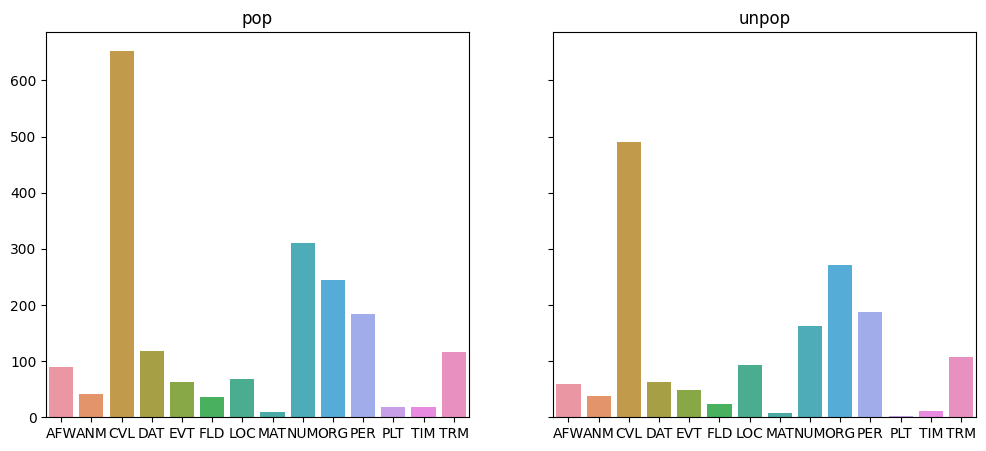

In [7]:
fig, ax = plt.subplots(1,2, sharey=True , figsize=(12,5)) 
sns.barplot(x = list(pop_all_label.keys()), y = list(pop_all_label.values()), ax= ax[0])
ax[0].set_title('pop')
sns.barplot(x = list(unpop_all_label.keys()), y = list(unpop_all_label.values()), ax= ax[1])
ax[1].set_title('unpop')
plt.show()

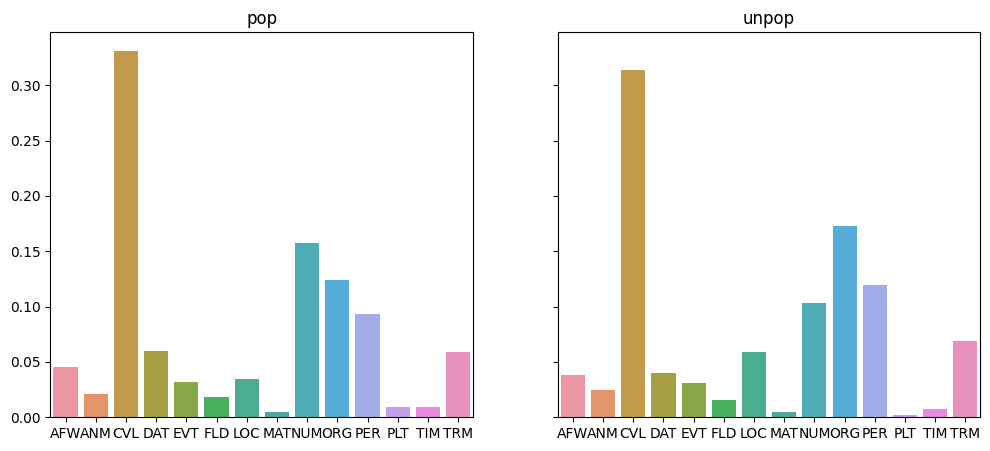

In [16]:
fig, ax = plt.subplots(1,2, sharey=True , figsize=(12,5)) 
sns.barplot(x = list(pop_ratio_data.keys()), y = list(pop_ratio_data.values()), ax=ax[0])
ax[0].set_title('pop')
sns.barplot(x = list(unpop_ratio_data.keys()), y = list(unpop_ratio_data.values()), ax=ax[1])
ax[1].set_title('unpop')
plt.show()

In [17]:
chi2_contingency([list(pop_all_label.values()), list(unpop_all_label.values())])

Chi2ContingencyResult(statistic=68.9875573727709, pvalue=1.2322699882733559e-09, dof=13, expected_freq=array([[ 83.56416054,  44.01045789, 637.31599774, 100.83408705,
         61.8374788 ,  33.42566422,  90.24929339,   9.47060486,
        262.94855851, 287.46071227, 206.68202374,  11.69898248,
         16.71283211, 124.78914641],
       [ 66.43583946,  34.98954211, 506.68400226,  80.16591295,
         49.1625212 ,  26.57433578,  71.75070661,   7.52939514,
        209.05144149, 228.53928773, 164.31797626,   9.30101752,
         13.28716789,  99.21085359]]))

In [18]:
chi2_contingency([list(unpop_ratio_data.values()), list(unpop_ratio_data.values())])

Chi2ContingencyResult(statistic=0.0, pvalue=1.0, dof=13, expected_freq=array([[0.03828973, 0.02425016, 0.31333759, 0.04020421, 0.03063178,
        0.01531589, 0.05934907, 0.00446713, 0.10338226, 0.17294193,
        0.11933631, 0.00191449, 0.00765795, 0.06892151],
       [0.03828973, 0.02425016, 0.31333759, 0.04020421, 0.03063178,
        0.01531589, 0.05934907, 0.00446713, 0.10338226, 0.17294193,
        0.11933631, 0.00191449, 0.00765795, 0.06892151]]))

크게 나오는 것
- CVL : 문명 및 문화 
- NUM : 숫자 
- PER : 인명

둘이 그나마 다른 것
- ORG : 기관 및 단체 
- TRM : 의학 / IT 용어

In [8]:
target = 'ORG'
select_group = []
for label, token in zip(pop_processing_df['NER-label'].to_list(),pop_processing_df['tokenize'].to_list()) :
    for label_2, token_2 in zip(ast.literal_eval(label),ast.literal_eval(token)) :
        if all([target in label_2, len(token_2) >1]) :
            select_group.append(token_2)

print(set(select_group))

{'##들면', '##하나는', '##가', '##님', '##국은', '##모', '##미', '##요', '##이지', '##냐', '##나와', '##피', '##일이', '##더', '##같이', '##약', '##한', '##뭐', '##스', '##라', '##겠나', '##이용', '##던', '##마이', '##이라', '##입', '##디', '##오니', '##거', '##너스', '##이고', '##도', '##짠', '##나', '##의', '##땅', '##이나', '##쪼', '##이라고', '##히', '##에', '##고대', '##죠', '##째', '대해서', '##은', '##쯤', '##가네', '##목', '##운데', '##중에', '##복', '혹시', '##수가', '다시한번', '##시기', '##수', '##라스', '##련', '##음', '##보면', '##야', '##고', '##대를', '##주고', '##를', '##하여', '##다', '##이런', '##근데', '##면', '##그리고', '##아아', '##격', '##쓰는', '넣어', '##보', '##되고', '##됨', '##플', '나눠', '##시', '##앞에', '##왜', '##맨', '##정', '##그', '##곧', '##시간', '됐다', '##라스틱', '##으면', '##렉', '##이렇게', '제거', '##찬', '주고', '##희', '##대구', '##분의', '##러스', '##마', '멀리', '##제', '##신경', '##트', '그분', '##하', '##곱', '##세', '따라서', '##일', '##할', '##따', '##방', '##대로', '##섀', '##배우', '##했는데', '##나이', '##온', '자유당', '##넣어', '##든', '##네', '##내', '##해제', '##서', '##한번', '##계속', '##얘기', '##위', '##또', '##그러', '##운', '##

In [9]:
target = 'ORG'
select_group = []
for label, token in zip(unpop_processing_df['NER-label'].to_list(),unpop_processing_df['tokenize'].to_list()) :
    for label_2, token_2 in zip(ast.literal_eval(label),ast.literal_eval(token)) :
        if all([target in label_2, len(token_2) >1]) :
            select_group.append(token_2)

print(set(select_group))

{'##보니까', '##위에', '##가', '##실은', '##실을', '##수는', '##재', '##국은', '##요', '##미', '##면서', '##어', '##껏', '##용', '##의가', '##아이', '##갑', '##씨', '##담', '##인', '##같이', '##한', '##스', '##라', '##이용', '##바이', '##마이', '##식이', '그러면', '스토', '##이라', '##다면', '##며', '##률', '##너스', '##비에', '##사이에', '##의', '없고', '##안보', '##에', '##은', '이때', '##신', '##이에', '##차반', '##루', '##복', '##으', '##혀', '##수', '##로', '##사', '##젤', '##푼', '##우리', '##번', '##야', '##고', '##트로', '##벨', '##탐', '##면', '##조', '최근', '##분해', '없이', '##세우고', '##빈', '##워야', '위에', '##쓰면', '##보', '##되고', '##플', '##다시', '##연', '##륜', '##랑', '##액', '##정', '##쭉', '##배', '##아들', '##얠', '기분', '##그제', '##화', '##희', '##유포', '##늦게', '##우스', '그네', '##분의', '##러스', '##마', '##다음', '##여기', '##쿨', '##있는', '##제', '##트', '##도우', '##칡', '##곱', '##즈', '##해서', '다음', '아마', '##리', '##어떤', '##일', '사도', '##아', '##형', '##곤', '##본', '##했던', '##흐', '##꺼', '##온', '##브', '##에도', '##네', '##서', '##분에', '이런', '##또', '##음식', '##이', '##그러', '삼성을', '##질', '##쩍', '##대', '##그냥', '##국', 